# Augmentation

Augmentation for MRI has its limitaions. The model needs to recognize a specific pattern or shape that is common for each class and it can be disturbed by the augmentation. I will fit the models using augmented images from ImageDataGenerator and Albumentations. Ideas for augmentation types suitable for medical images I took from [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5977656/) 

In [2]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2S, resnet50
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow import expand_dims

import albumentations as A
import cv2
from os import listdir
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import functions

import numpy as np
np.random.seed(18)

In [3]:
# Set image size
image_size = 240

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Path to Alzheimer's data
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Path to Brain Tumor data
bt_path_train = '../data/brain_tumor/train'
bt_path_test = '../data/brain_tumor/test'

In [4]:
def ald_augmentation(X_train, y_train):
    '''
    Augment the data and return initial data combined with augmented prepared for TensorFlow models
    Input:
    X_train - list, preprocessed training images to be augmented.
    y_train - list, labels for images
    Return:
    X_train with initial images combined with augmented and y_train with labels for all X_train images prepared for TensorFlow models.
    '''
    # Augment the data
    X_aug = []
    for image in X_train:
        image = transform(image=image)['image']
        image = cv2.resize(image, (image_size, image_size))
        X_aug.append(image)
    # Add augmented data to training set
    X_train = X_train + X_aug
    y_train = y_train + y_train
    # Prepare data for Tensorflow model
    X_train = np.array(X_train, dtype='float32')
    y_train = to_categorical(y_train, num_classes=4, dtype='float32')
    return X_train, y_train

In [5]:
def alb_prepare_data(path):
    '''
    Read the data from the path, convert grayscale to RGB, apply augmentation and prepare for TensorFlow models.
    Input: path - str, path to the images folder
    Return: 
    For Training set - return  X_train, X_val, y_train, y_val (arrays, ready for TensorFlow models), with X_train and y_train augmented
    For Test set - return X_test, y_test (arrays, ready for TensorFlow models)
    '''
    X = []
    y = []

    for num_label, label in enumerate(listdir(path)):
            # Change each image and append to X and y
            for image in listdir(f'{path}/{label}'):
                if '.jpg' in image:
                    img = load_img(f'{path}/{label}/{image}', target_size=(image_size, image_size), color_mode='grayscale')
                    img = expand_dims(img, -1)
                    # Make image RGB for pre-trained models
                    img = grayscale_to_rgb(img)
                    img_arr = img_to_array(img) 

                    X.append(img_arr)
                    y.append(num_label)
                    
    if 'train' in path:     
            X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
                   
            X_val = np.array(X_val, dtype='float32')
            y_val = to_categorical(y_val, num_classes=4, dtype='float32')
            # Apply augmentation on trainig set 
            X_train, y_train = ald_augmentation(X_train, y_train)
            return X_train, X_val, y_train, y_val
    else:
            
            X_test = np.array(X, dtype='float32')
            y_test = to_categorical(y, num_classes=4, dtype='float32')
            return X_test, y_test

In [53]:
# Transformations to be applied to the training set. I have tried different probabilities, adding RandomScale and RandomBrightnessContrast with different probabilities. This combination of Augmentations and probabilities gave a maximal increase in the accuracy of the best models from previous notebooks.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.5),
    A.Rotate(limit=10, p=0.5),    
])

### Alzheimer's

In [42]:
X_train, X_val, y_train, y_val = alb_prepare_data(al_path_train)
# Check the shape of the data
X_train.shape, y_train.shape

((7680, 240, 240, 3), (7680, 4))

In [26]:
X_test, y_test = alb_prepare_data(al_path_test)

In [8]:
# This model gave better scores on non augmented data
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [9]:
# Freeze layers
for layer in rn_model.layers:
    layer.trainable = False

In [46]:
model = Sequential()

model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), steps_per_epoch=len(X_train) / 32, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
240/240 [==============================] - 658s 3s/step - loss: 5.3511 - accuracy: 0.5607 - val_loss: 13.3514 - val_accuracy: 0.5995 - lr: 0.0010
Epoch 2/30
240/240 [==============================] - 666s 3s/step - loss: 2.8846 - accuracy: 0.6940 - val_loss: 1.2842 - val_accuracy: 0.8228 - lr: 0.0010
Epoch 3/30
240/240 [==============================] - 905s 4s/step - loss: 1.6280 - accuracy: 0.7707 - val_loss: 2.7237 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 4/30
240/240 [==============================] - 1015s 4s/step - loss: 1.6515 - accuracy: 0.7837 - val_loss: 1.8538 - val_accuracy: 0.7986 - lr: 0.0010
Epoch 5/30
240/240 [==============================] - 1034s 4s/step - loss: 2.1410 - accuracy: 0.7715 - val_loss: 1.4721 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 6/30
240/240 [==============================] - 1019s 4s/step - loss: 1.3690 - accuracy: 0.8266 - val_loss: 2.0237 - val_accuracy: 0.8158 - lr: 0.0010
Epoch 7/30
240/240 [==============================] - 1034s 

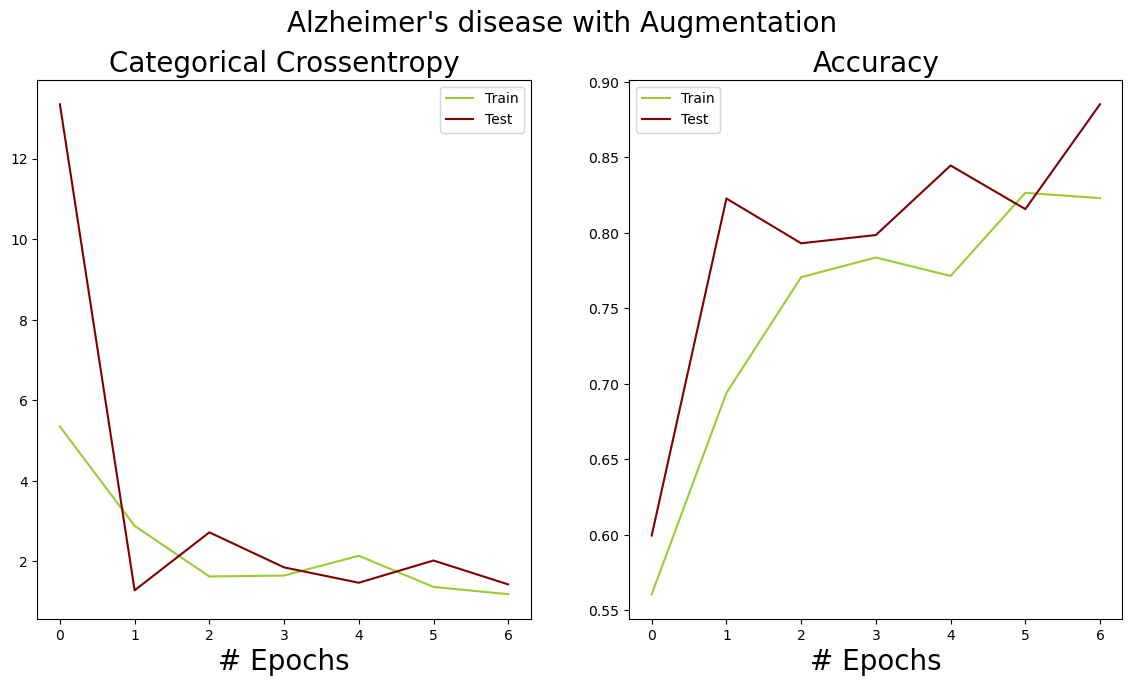

In [47]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with Augmentation')

Accuracy_score: 0.8228 



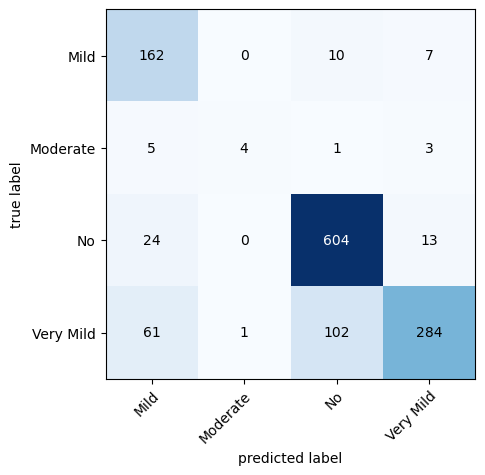

In [48]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.674 



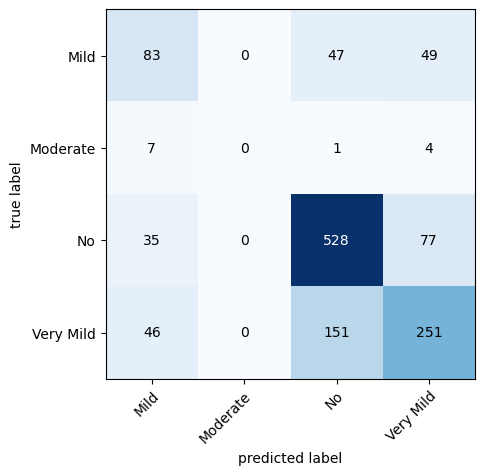

In [49]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Augmentation did not improve the accuracy of the model (This was the best accuracy I have achieved by trying different combinations of augmentations and probabilities). Without Augmentation, accuracy was 0.67

### Brain Tumor

In [47]:
X_train, X_val, y_train, y_val = alb_prepare_data(bt_path_train)
X_train.shape, y_train.shape

((4304, 240, 240, 3), (4304, 4))

In [14]:
X_test, y_test = alb_prepare_data(bt_path_test)

In [15]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax",
    include_preprocessing=True,
)
# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

In [49]:
model = Sequential()

model.add(effnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_efv2s = model.fit(X_train, y_train, validation_data = (X_val, y_val), steps_per_epoch=len(X_train) / 32, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
134/134 [==============================] - 370s 3s/step - loss: 0.5827 - accuracy: 0.7558 - val_loss: 0.2330 - val_accuracy: 0.9164 - lr: 0.0010
Epoch 2/30
134/134 [==============================] - 334s 2s/step - loss: 0.4066 - accuracy: 0.8241 - val_loss: 0.1987 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 3/30
134/134 [==============================] - 331s 2s/step - loss: 0.3620 - accuracy: 0.8462 - val_loss: 0.2004 - val_accuracy: 0.9290 - lr: 0.0010
Epoch 4/30
134/134 [==============================] - 335s 2s/step - loss: 0.3442 - accuracy: 0.8571 - val_loss: 0.1984 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 5/30
134/134 [==============================] - 337s 3s/step - loss: 0.3395 - accuracy: 0.8515 - val_loss: 0.1960 - val_accuracy: 0.9290 - lr: 0.0010
Epoch 6/30
134/134 [==============================] - 338s 3s/step - loss: 0.3243 - accuracy: 0.8578 - val_loss: 0.1863 - val_accuracy: 0.9373 - lr: 0.0010
Epoch 7/30
134/134 [==============================] - 332s 2s/st

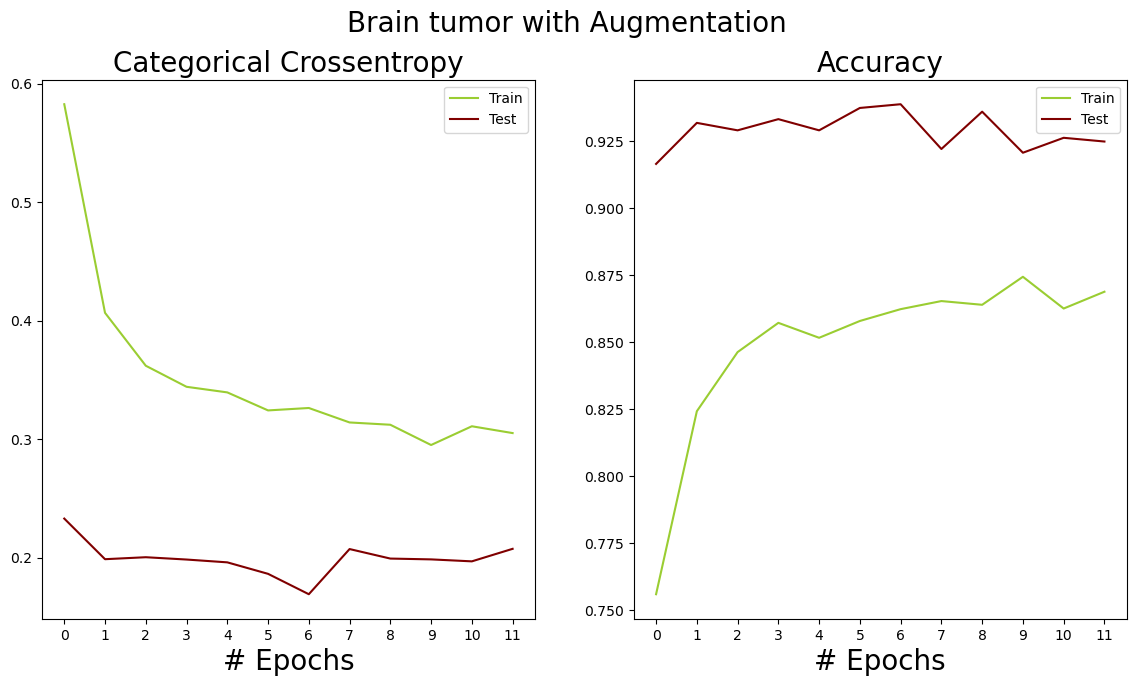

In [50]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_efv2s, 'Brain tumor with Augmentation')

Accuracy_score: 0.9387 



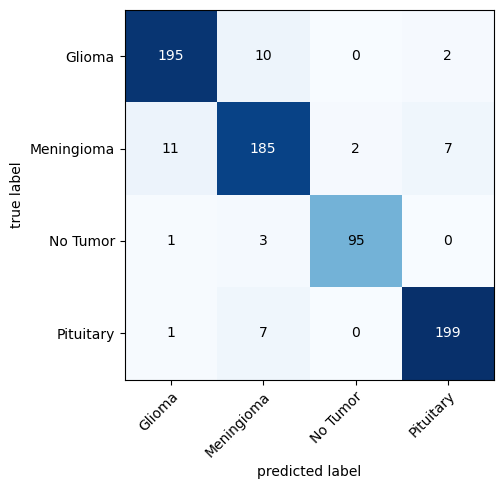

In [51]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])

Accuracy_score: 0.7817 



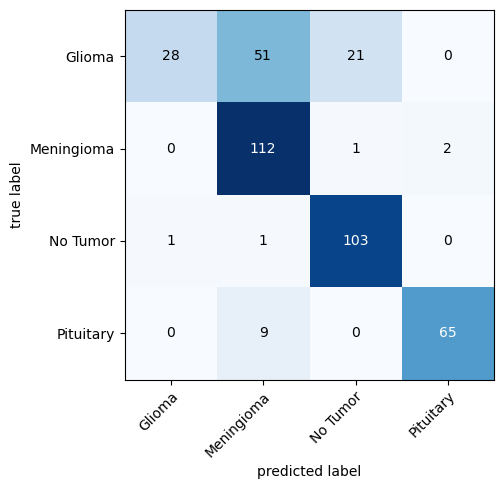

In [52]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])

Augmentation increaced the accuracy from 75% to 78%

---

I have tried augmenting images using Albumentations on the best models from the previous two notebooks. For Alzheimer's, the accuracy stayed the same and for the Brain tumor classification accuracy increased. I will try models with and without Albumentation augmentations on the final models for the Streamlit application.